<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/01.%20Machine%20Learning/13.%20Week%2013/Notebook/SentimentAnalysisDatasetSintesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Beberapa contoh frasa pendek (sangat sederhana) untuk setiap sentimen
positive_phrases = [
    "Saya sangat menyukai produk ini",
    "Pelayanannya cepat dan memuaskan",
    "Kualitasnya luar biasa",
    "Bagus, saya akan beli lagi",
    "Pengalaman yang menyenangkan",
    "Sangat direkomendasikan",
    "Harganya terjangkau dan kualitas oke",
    "Suka sekali dengan fitur barunya",
    "Layanan pelanggan sangat membantu",
    "Pengiriman tepat waktu"
]

negative_phrases = [
    "Saya kecewa dengan hasilnya",
    "Produk ini cacat",
    "Sangat buruk, tidak menyarankan",
    "Layanan pelanggan tidak membantu",
    "Pengiriman sangat terlambat",
    "Tidak sesuai harapan",
    "Menghabiskan uang saja",
    "Kualitasnya jelek",
    "Sangat mengecewakan",
    "Pelayanannya buruk"
]

neutral_phrases = [
    "Produk ini biasa saja",
    "Tidak ada yang spesial",
    "Biasa, sesuai harganya",
    "Pengirimannya lumayan",
    "Saya belum punya pendapat",
    "Sebanding dengan harga",
    "Cukup netral",
    "Saya tidak yakin",
    "Lumayan untuk dicoba",
    "Tidak buruk tapi juga tidak bagus"
]

def generate_synthetic_sentences(phrases, num_samples):
    """
    Mengambil frase dari list phrases secara acak untuk membuat kalimat-kalimat sintetis.
    """
    data = []
    for _ in range(num_samples):
        # Pilih secara acak
        sentence = random.choice(phrases)
        data.append(sentence)
    return data

num_samples_per_class = 100

positive_samples = generate_synthetic_sentences(positive_phrases, num_samples_per_class)
negative_samples = generate_synthetic_sentences(negative_phrases, num_samples_per_class)
neutral_samples  = generate_synthetic_sentences(neutral_phrases, num_samples_per_class)

# Membuat label: positif=1, negatif=-1, netral=0
positive_labels = [1]*num_samples_per_class
negative_labels = [-1]*num_samples_per_class
neutral_labels  = [0]*num_samples_per_class

# Gabungkan
all_sentences = positive_samples + negative_samples + neutral_samples
all_labels    = positive_labels + negative_labels + neutral_labels

# Masukkan ke dalam DataFrame
df = pd.DataFrame({
    "text": all_sentences,
    "label": all_labels
})

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(10)

,text,label
0,Cukup netral,0
1,Saya tidak yakin,0
2,Sangat mengecewakan,-1
3,Sangat direkomendasikan,1
4,Lumayan untuk dicoba,0
5,Produk ini biasa saja,0
6,Produk ini cacat,-1
7,Produk ini cacat,-1
8,Saya sangat menyukai produk ini,1
9,Tidak sesuai harapan,-1


In [3]:
# Lowercasing sederhana
df['text'] = df['text'].str.lower()

# Cek hasil
df.head()

,text,label
0,cukup netral,0
1,saya tidak yakin,0
2,sangat mengecewakan,-1
3,sangat direkomendasikan,1
4,lumayan untuk dicoba,0


In [4]:
X = df['text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data latih  :", len(X_train))
print("Jumlah data uji    :", len(X_test))

Jumlah data latih  : 240
Jumlah data uji    : 60


In [5]:
# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Konversi text -> sequence of integers
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences  = tokenizer.texts_to_sequences(X_test)

# Tentukan panjang maksimal untuk padding
max_length = 10
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded  = pad_sequences(test_sequences,  maxlen=max_length, padding='post', truncating='post')

In [6]:
def build_model(vocab_size, embedding_dim, max_length, rnn_type="rnn"):
    """
    Membangun model Sequential dengan:
    - Embedding layer
    - Recurrent layer (RNN / LSTM / GRU)
    - Dense output (1 neuron, activation='sigmoid' atau 'tanh' sesuai task)
      karena di sini kita punya label: -1, 0, 1 (multi-class)...

    Namun, agar mudah, kita *encoding* -1, 0, 1 menjadi 0,1,2 dulu.
    (Bisa juga 3 neuron output. Kita pakai output 3 neuron + softmax)
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

    if rnn_type == "rnn":
        model.add(SimpleRNN(64, return_sequences=False))
    elif rnn_type == "lstm":
        model.add(LSTM(64, return_sequences=False))
    elif rnn_type == "gru":
        model.add(GRU(64, return_sequences=False))
    else:
        raise ValueError("rnn_type harus 'rnn', 'lstm', atau 'gru'")

    # Dense layer untuk multi-class (3 kelas)
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [7]:
from tensorflow.keras.utils import to_categorical

def encode_label(y):
    """
    Mengubah label -1 -> 0, 0 -> 1, 1 -> 2.
    """
    y_encoded = []
    for val in y:
        if val == -1:
            y_encoded.append(0)
        elif val == 0:
            y_encoded.append(1)
        elif val == 1:
            y_encoded.append(2)
    return np.array(y_encoded)

y_train_enc = encode_label(y_train)
y_test_enc  = encode_label(y_test)

# One-hot encoding
y_train_cat = to_categorical(y_train_enc, num_classes=3)
y_test_cat  = to_categorical(y_test_enc, num_classes=3)

In [8]:
vocab_size = 2000   # harus >= nilai num_words di Tokenizer
embedding_dim = 32  # bebas kita tentukan
num_epochs = 5

histories = {}
models = {}

for rnn_type in ["rnn", "lstm", "gru"]:
    print(f"\nTraining model: {rnn_type.upper()}")
    model = build_model(vocab_size, embedding_dim, max_length, rnn_type=rnn_type)
    history = model.fit(
        train_padded, y_train_cat,
        epochs=num_epochs,
        validation_split=0.2,
        verbose=1
    )

    # Simpan model & history
    models[rnn_type] = model
    histories[rnn_type] = history


Training model: RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5032 - loss: 1.0849 - val_accuracy: 0.8958 - val_loss: 0.9554
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8671 - loss: 0.9240 - val_accuracy: 0.8958 - val_loss: 0.7487
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9106 - loss: 0.6719 - val_accuracy: 0.9583 - val_loss: 0.4373
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9612 - loss: 0.3624 - val_accuracy: 1.0000 - val_loss: 0.1896
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9739 - loss: 0.1634 - val_accuracy: 1.0000 - val_loss: 0.0711

Training model: LSTM
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3280 - loss: 1.1017 - val_accuracy: 0.6667 - val_loss: 1.0956
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6422 - loss: 1.0960 - val_accuracy: 0.3958 - val_loss: 1.0917
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4237 - loss: 1.0897 - val_accuracy: 0.2917 - val

In [9]:
for rnn_type in ["rnn", "lstm", "gru"]:
    print(f"\nEvaluasi model: {rnn_type.upper()}")
    model = models[rnn_type]
    y_pred_prob = model.predict(test_padded)
    # Ambil argmax -> 0,1,2
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Bandingkan dengan y_test_enc
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"Akurasi pada data uji = {acc:.4f}")

    # Classification report
    print(classification_report(y_test_enc, y_pred, target_names=['negatif', 'netral', 'positif']))


Evaluasi model: RNN
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Akurasi pada data uji = 1.0000
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        20
      netral       1.00      1.00      1.00        20
     positif       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Evaluasi model: LSTM
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Akurasi pada data uji = 0.9667
              precision    recall  f1-score   support

     negatif       0.91      1.00      0.95        20
      netral       1.00      1.00      1.00        20
     positif       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Evaluasi model: GRU


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Akurasi pada data uji = 0.3333
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        20
      netral       0.33      1.00      0.50        20
     positif       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


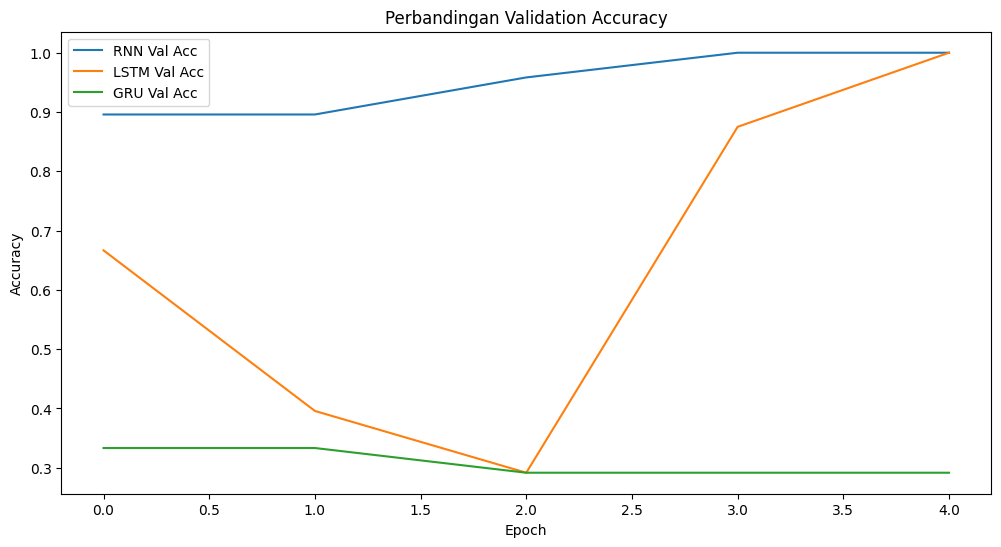

In [10]:
plt.figure(figsize=(12, 6))

for rnn_type in ["rnn", "lstm", "gru"]:
    history = histories[rnn_type]
    plt.plot(history.history['val_accuracy'], label=f"{rnn_type.upper()} Val Acc")

plt.title("Perbandingan Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()